# Regression Analysis of Stock Prices Using `stockpy`

In this tutorial, we will demonstrate how to conduct regression analysis on stock price data using a Convolutional Neural Network (CNN) with the `stockpy` library.

## Setting Up

First, import all necessary modules from PyTorch, Pyro, `stockpy`, and other required libraries.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import stockpy
import pyro.distributions as dist
from pyro.infer import Trace_ELBO, TraceMeanField_ELBO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stockpy.neural_network import *
from stockpy.probabilistic import *

# Data Preparation

Load and preprocess your stock price data for the model.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('../stock/AAPL.csv', parse_dates=True, index_col='Date').dropna(how="any")

# Define features and target
X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Close']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Data Normalization

Standardize the features to have a mean of 0 and a standard deviation of 1.

In [3]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Conversion to PyTorch Tensors

Convert the datasets into PyTorch tensors to feed into the model.

In [4]:
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float)

# Callbacks Configuration

Set up callbacks for early stopping and learning rate scheduling.

In [5]:
from stockpy.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import StepLR
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=5,
    threshold=0,
    threshold_mode='rel',
    lower_is_better=True)

checkpoint = Checkpoint(
    f_params='best_model_params.pt',       # where to save the model parameters
    monitor='valid_loss_best',             # name of the variable that should be minimized
    f_optimizer='best_optimizer_params.pt',  # where to save the optimizer
    f_history='best_model_history.json',   # where to save the training history
)

# Define the LR scheduler callback
lr_scheduler = LRScheduler(policy=StepLR, step_size=10, gamma=0.7)  # Added this line

# Model Training

Define and train the CNN model using the `stockpy` library.

In [6]:
predictor = CNNRegressor(hidden_size=32)

predictor.fit(X_train, 
              y_train, 
              batch_size=32, 
              lr=0.01, 
              optimizer=torch.optim.Adam, 
              callbacks=[early_stopping, checkpoint, lr_scheduler],
              epochs=50)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     7932.8646     1011.6140  0.1080


      2     5689.1491      508.1322  0.0919
      3     2578.8606      160.0544  0.0900
      4      660.5543      195.9205  0.0764
      5      353.5841      229.0921  0.0814
      6      322.1602      198.7331  0.0838
      7      283.1927      174.7743  0.0776
      8      247.0685      156.1367  0.0842
      9      215.7208      139.8686  0.0836
     10      187.6797      125.4506  0.1056
     11      161.4707      113.3362  0.1111
     12      145.5999      103.6728  0.2049
     13      130.5872       95.2585  0.1117
     14      116.5061       87.3664  0.1043
     15      103.1182       79.8680  0.0917
     16       90.4452       73.2412  0.1003
     17       79.2393       67.8735  0.1050
     18       69.3897       62.9776  0.1390
     19       60.5278       58.3952  0.1102
     20       52.5829       53.9658  0.0870
     21       44.7664       49.7275  0.0807
     22       40.3406       46.4108  0.0977
     23       36.1590       43.7191  0.0883
     24       32.3822       41.5

<class 'stockpy.neural_network._cnn.CNNRegressor'>[initialized](
)

# Prediction and Evaluation

Predict the closing stock prices and evaluate the model's performance.

In [25]:
y_pred = predictor.predict(X_test)

In [26]:
def evaluate(y_test, y_pred, show=False):
    # Ensure y_test and y_pred are tensors and have the same shape
    y_test = torch.tensor(y_test).view(-1, 1)
    y_pred = torch.tensor(y_pred).view(-1, 1)
    
    mse = torch.nn.MSELoss()(y_pred, y_test)
    rmse = torch.sqrt(mse)
    mape = torch.mean(torch.abs((y_test - y_pred) / y_test)) * 100

    if show:
        print('Model Performance')
        print("Mean squared error = {:0.3f}".format(mse))
        print("Root mean squared error = {:0.3f}".format(rmse))
        print('Mean absolute percentage error = {:0.3f}%.'.format(mape))
    else:
        return mse.item(), rmse.item(), mape.item()

def plot_predictions(X, y_test, y_pred, mse, mse_squar, mape, predictor):
    sns.set(style="ticks", context="talk")
    plt.style.use('dark_background')
    file = '../results/regressor' + predictor.__class__.__name__ + '.png'
    fig, ax = plt.subplots(figsize=(12, 6))
    days = X[len(X) - len(y_test):].index
    ax.plot(days, y_test, label='Close Value', linewidth=3, color='#2962FF')
    ax.plot(days, y_pred, label='predicted', linewidth=3, color='#FFA726')
    ax.set_title('Apple stock', fontsize=24, color='white')
    ax.set_xlabel('Time', fontsize=16, color='white', labelpad=10)
    ax.set_ylabel('Close price', fontsize=16, color='white', labelpad=10)
    ax.grid(color='white', linestyle='--', linewidth=0.5)

    # Add crosses at points where predicted value matches true value
    for i in range(len(days)):
        # if y_test is numpy array
        if isinstance(y_test, np.ndarray):
            if abs(y_test[i] - y_pred[i]) < 0.1:
                ax.scatter(days[i], y_test[i], marker='X', color='white', 
                                s=100, zorder=2)
        else:
            if abs(y_test.iloc[i] - y_pred[i]) < 0.1:
                ax.scatter(days[i], y_test[i], marker='X', color='white', 
                                s=100, zorder=2)

    # put legend in a white box
    ax.legend(fontsize=16, loc='upper right', 
              edgecolor='black')

    fig.autofmt_xdate()
    # these are matplotlib.patch.Patch properties
    textstr = '\n'.join((
        r'$\mathrm{MSE}: %.2f$' % (mse, ),
        r'$\mathrm{RMSE}: %.2f$' % (mse_squar, ),  
        r'$\mathrm{MAPE}: %.2f$' % (mape, )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.15, textstr, transform=ax.transAxes, fontsize=14,
            ha='left', va='center', bbox=props)

    plt.show()

/tmp/ipykernel_363480/680147880.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = torch.tensor(y_test).view(-1, 1)
/tmp/ipykernel_363480/680147880.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(days[i], y_test[i], marker='X', color='white',


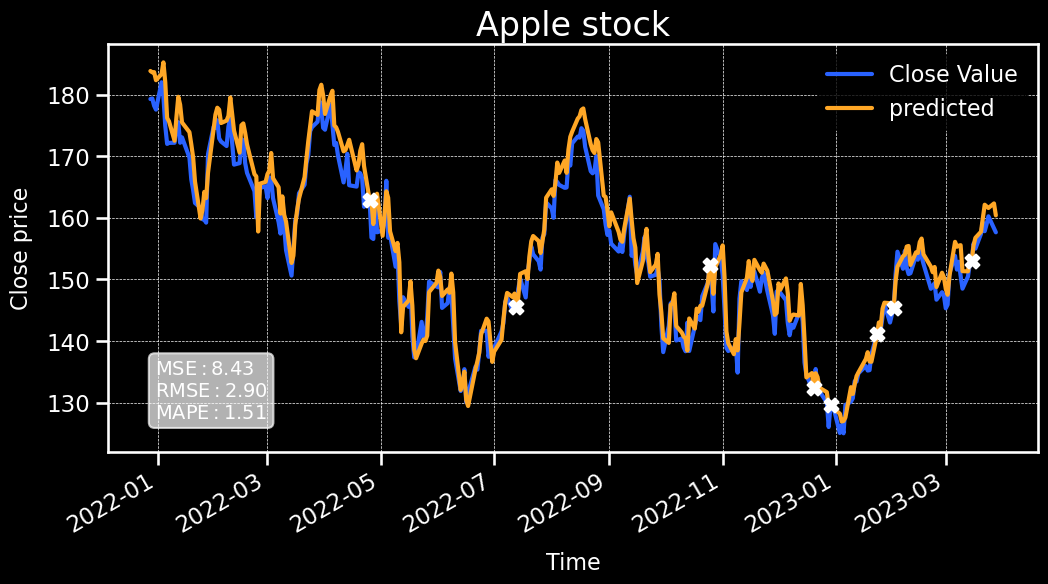

In [27]:
mse, mse_squar, mape = evaluate(y_test, y_pred, show=False)

plot_predictions(X, y_test, y_pred, mse, mse_squar, mape, predictor)